# Optimization of Nonlocality against CHSH Inequality

This notebook considers the bipartite, nonsignaling CHSH scenario.

<div>
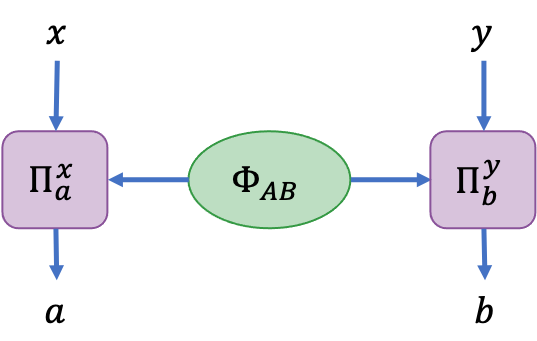
</div>
    
<!-- <img src="images/chsh_scenario.png" alt="chsh scenario" width="200"/> -->

Here $x$, $y$, $a$, and $b$ are all classical, binary values.
In this scenario, quantum probabilities are constructed as $P(ab|xy) = \text{Tr}[\Pi_a^x\otimes\Pi_b^y\Phi_{AB}]$ and expectation values for a particular observable are defined as
$\langle A_xB_y\rangle = \sum_{a,b\in\{0,1\}} (-1)^{a+b}P(ab|xy)$.
The CHSH inequality is then

$$
\langle A_0B_0\rangle + \langle A_0 B_1\rangle \langle A_1 B_0 \rangle - \langle A_1 B_1 \rangle \leq 2.
$$

For quantum systems, the left hand side can be as large as $2\sqrt{2}$.

### Goal: Find a set of states and measurements that optimally violate the CHSH inequality.

In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

from context import qnetvo as QNopt

### Setup the Ansatz Circuits and Cost Functions

In [2]:
def bell_state_RY(settings, wires):
    qml.Hadamard(wires=wires[0])
    qml.CNOT(wires=[wires[0],wires[1]])
    
    qml.RY(settings[0], wires=wires[0])
    qml.RY(settings[1], wires=wires[1])

RY_prep_nodes = [
    QNopt.PrepareNode(1, [0,1], bell_state_RY, 2)
]
RY_meas_nodes = [
    QNopt.MeasureNode(2, 2, [0], QNopt.local_RY, 1),
    QNopt.MeasureNode(2, 2, [1], QNopt.local_RY, 1),
]

real_chsh_ansatz = QNopt.NetworkAnsatz(RY_prep_nodes, RY_meas_nodes)

arb_prep_nodes = [
    QNopt.PrepareNode(1, [0,1], qml.templates.subroutines.ArbitraryUnitary, 15)
]
arb_meas_nodes = [
    QNopt.MeasureNode(2, 2, [0], qml.templates.subroutines.ArbitraryUnitary, 3),
    QNopt.MeasureNode(2, 2, [1], qml.templates.subroutines.ArbitraryUnitary, 3),
]

arb_chsh_ansatz = QNopt.NetworkAnsatz(arb_prep_nodes, arb_meas_nodes)

real_chsh_cost = QNopt.chsh_inequality_cost(real_chsh_ansatz)
arb_chsh_cost = QNopt.chsh_inequality_cost(arb_chsh_ansatz)

### Optimizing the CHSH circuit over the real parameter space

In [3]:
np.random.seed(66)
real_settings = real_chsh_ansatz.rand_scenario_settings()

real_opt_dict = QNopt.gradient_descent(
    real_chsh_cost,
    real_settings,
    step_size=0.1,
    sample_width=1,
    num_steps=20,
    verbose=False
)

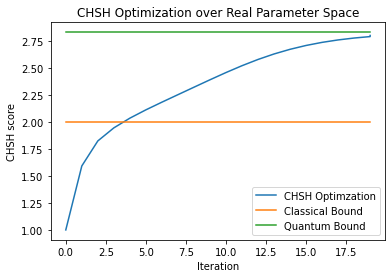

In [4]:
# Plot the individual observables
plt.plot(real_opt_dict["samples"], real_opt_dict["scores"] , label = "CHSH Optimzation")
plt.plot(real_opt_dict["samples"], [2]*len(real_opt_dict["samples"]), label = "Classical Bound")
plt.plot(real_opt_dict["samples"], [2*np.sqrt(2)]*len(real_opt_dict["samples"]), label = "Quantum Bound")
plt.title("CHSH Optimization over Real Parameter Space")
plt.xlabel("Iteration")
plt.ylabel("CHSH score")
plt.legend()
plt.show()

### Optimizing the CHSH circuit over general parameter space

In [5]:
np.random.seed(66)
arb_settings = arb_chsh_ansatz.rand_scenario_settings()

arb_opt_dict = QNopt.gradient_descent(
    arb_chsh_cost,
    arb_settings,
    step_size=0.1,
    sample_width=1,
    num_steps=20,
    verbose=False
)

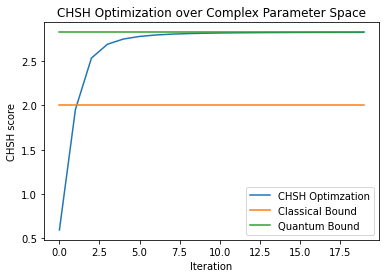

In [6]:
# Plot the individual observables
plt.plot(arb_opt_dict["samples"], arb_opt_dict["scores"], label = "CHSH Optimzation")
plt.plot(arb_opt_dict["samples"], [2]*len(arb_opt_dict["samples"]), label = "Classical Bound")
plt.plot(arb_opt_dict["samples"], [2*np.sqrt(2)]*len(arb_opt_dict["samples"]), label = "Quantum Bound")
plt.title("CHSH Optimization over Complex Parameter Space")
plt.xlabel("Iteration")
plt.ylabel("CHSH score")
plt.legend()
plt.show()